# Missing value interpolation

In [1]:
import numpy as np
from gammapy.maps import MapAxis
from gammapy.irf import Background3D
from astropy import units as u
from scipy.ndimage.measurements import label
from gammapy.utils.interpolation import interpolation_scale
import matplotlib.pyplot as plt

In [2]:
def bkg_3d_interp():
    """Example with simple values to test evaluate"""
    energy = np.logspace(-1, 3, 6) * u.TeV
    energy_axis = MapAxis.from_energy_edges(energy)

    fov_lon = [0, 1, 2, 3] * u.deg
    fov_lon_axis = MapAxis.from_edges(fov_lon, name="fov_lon")

    fov_lat = [0, 1, 2, 3] * u.deg
    fov_lat_axis = MapAxis.from_edges(fov_lat, name="fov_lat")

    data = np.ones((5, 3, 3)) * np.geomspace(0.1, 10, 5).reshape((-1, 1, 1))

    data[-2, :, :] = np.nan
    data[0, 0, 0] = np.nan
    # clipping of value before last will cause extrapolation problems
    # as found with CTA background IRF

    bkg = Background3D(
        axes=[energy_axis, fov_lon_axis, fov_lat_axis],
        data=data,
        unit="s-1 GeV-1 sr-1",
    )
    return bkg

In [3]:
bkg = bkg_3d_interp()

In [4]:
def interp_missing_data(self, axis_name):
    """Interpolate missing data along a given axis"""
    values_scale = self.default_interp_kwargs.get("values_scale", "lin")
    scale = interpolation_scale(values_scale)
    
    axis = self.axes.index(axis_name)
    mask = np.isnan(self.data)
    
    coords = np.where(mask)
    xp = np.arange(self.data.shape[axis])

    for coord in zip(*coords):
        idx = list(coord)
        idx[axis] = slice(None)
        fp = self.data[tuple(idx)]
        valid = ~mask[tuple(idx)]
        
        value = np.interp(
            x=coord[axis], xp=xp[valid], fp=scale(fp[valid]), left=np.nan, right=np.nan
        )

        if not np.isnan(value):
            self.data[coord] = scale.inverse(value)



In [5]:
bkg_1 = bkg_3d_interp()

In [6]:
%%timeit
bkg_1.interp_missing_data()

346 µs ± 29.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
bkg_1.data

array([[[ 0.        ,  0.1       ,  0.1       ],
        [ 0.1       ,  0.1       ,  0.1       ],
        [ 0.1       ,  0.1       ,  0.1       ]],

       [[ 0.31622777,  0.31622777,  0.31622777],
        [ 0.31622777,  0.31622777,  0.31622777],
        [ 0.31622777,  0.31622777,  0.31622777]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 0.        ,  3.16227766,  3.16227766],
        [ 3.16227766,  3.16227766,  3.16227766],
        [ 3.16227766,  3.16227766,  3.16227766]],

       [[10.        , 10.        , 10.        ],
        [10.        , 10.        , 10.        ],
        [10.        , 10.        , 10.        ]]])

In [8]:
bkg_2 = bkg_3d_interp()

In [9]:
%%timeit
interp_missing_data(bkg_2, axis_name="energy")

43.9 µs ± 4.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
bkg_2.data

array([[[        nan,  0.1       ,  0.1       ],
        [ 0.1       ,  0.1       ,  0.1       ],
        [ 0.1       ,  0.1       ,  0.1       ]],

       [[ 0.31622777,  0.31622777,  0.31622777],
        [ 0.31622777,  0.31622777,  0.31622777],
        [ 0.31622777,  0.31622777,  0.31622777]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 3.16227766,  3.16227766,  3.16227766],
        [ 3.16227766,  3.16227766,  3.16227766],
        [ 3.16227766,  3.16227766,  3.16227766]],

       [[10.        , 10.        , 10.        ],
        [10.        , 10.        , 10.        ],
        [10.        , 10.        , 10.        ]]])

In [11]:
bkg_hess = Background3D.read("$GAMMAPY_DATA/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020136.fits.gz", hdu="BKG")
bkg_hess.data[16, :, :] = 0

In [12]:
%%time
bkg_hess.interp_missing_data()

CPU times: user 600 ms, sys: 14.9 ms, total: 615 ms
Wall time: 609 ms


/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


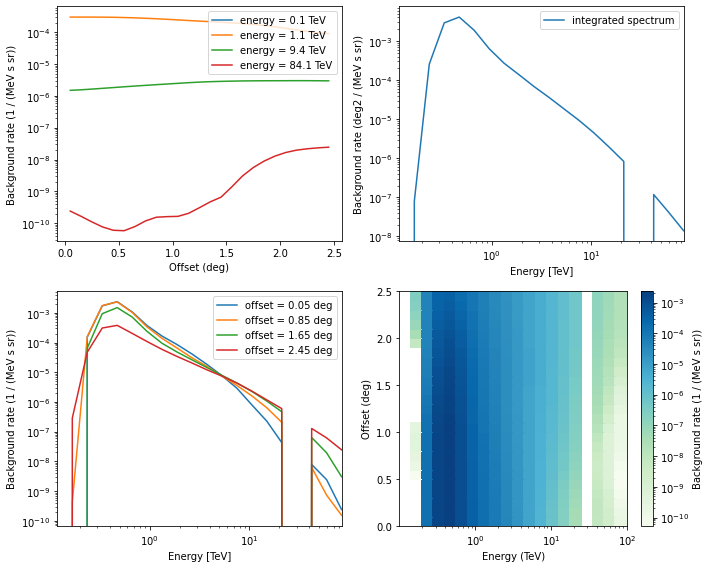

In [13]:
bkg_hess.peek()

In [14]:
bkg_hess_new = Background3D.read("$GAMMAPY_DATA/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020136.fits.gz", hdu="BKG")
bkg_hess_new.data[16, :, :] = np.nan

In [15]:
%%time
interp_missing_data(bkg_hess_new, axis_name="energy")

CPU times: user 72.5 ms, sys: 2.37 ms, total: 74.8 ms
Wall time: 80.4 ms


/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


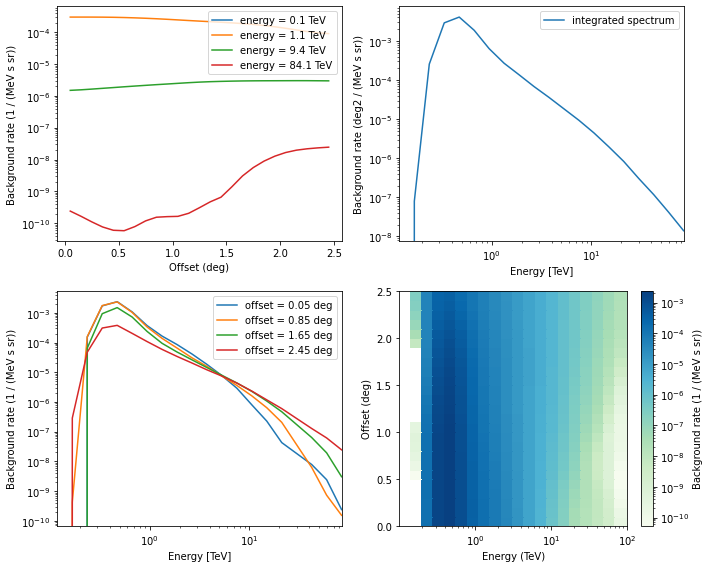

In [16]:
bkg_hess_new.peek()